# Demographic Analysis

More details on this analysis are [available here](../README.md).

In [1]:
import requests
import lxml.html
import cssselect
import pandas as pd
import matplotlib as mpl
%matplotlib inline

## Load "Voter Power Index" scores

In [2]:
voter_power_index = pd.read_csv("../data/fivethirtyeight/voter-power-index.csv")

In [3]:
voter_power_index.head()

,abbrev,power,state_raw,state
0,NH,5.6,New Hampshire,NEW HAMPSHIRE
1,NV,4.9,Nevada,NEVADA
2,NM,4.7,New Mexico,NEW MEXICO
3,MI,3.1,Michigan,MICHIGAN
4,CO,3.1,Colorado,COLORADO


## Load state registered voter counts, by demographic

In [4]:
demo_by_state = pd.read_csv(
    "../data/census/Table4b_2012.csv",
    skiprows=3,
    skipfooter=10,
    na_values=["-"],
    engine='python'
).pipe(lambda x: x[x.columns[0:14]])

In [5]:
demo_by_state.head()

,State,Race and Hispanic origin,Total Population,Total Citizen Population,Total registered,Percent registered (Total),Margin of Error1,Percent registered (Citizen),Margin of Error,Total voted,Percent voted (Total),Margin of Error.1,Percent voted (Citizen),Margin of Error.2
0,All,Total,"235,248","215,081","153,157",65.1,0.3,71.2,0.3,"132,948",56.5,0.3,61.8,0.3
1,NaN,Male,"113,243","103,022","71,414",63.1,0.4,69.3,0.4,"61,551",54.4,0.4,59.7,0.4
2,NaN,Female,"122,005","112,059","81,743",67.0,0.4,72.9,0.4,"71,397",58.5,0.4,63.7,0.4
3,NaN,White alone,"187,084","173,466","124,697",66.7,0.3,71.9,0.3,"107,846",57.6,0.3,62.2,0.3
4,NaN,.White non-Hispanic alone,"155,615","152,862","112,706",72.4,0.3,73.7,0.3,"98,041",63.0,0.3,64.1,0.3


In [6]:
demo_by_state["State"] = demo_by_state["State"].fillna(method="ffill")

In [7]:
demo_by_state.columns = [
    "state", "demographic", "total_pop", "total_citizen_pop", "total_registered", 
   "pct_registered", "moe_registered", "pct_registered_citizen", 
   "moe_registered_citizen", "total_voted", "pct_voted", "moe_voted", 
   "percent_voted_citizen", "moe_voted_citizen"
]

In [8]:
demo_by_state["total_registered"] = demo_by_state["total_registered"].apply(lambda x: float(str(x).replace(",", "")))

In [9]:
demo_by_state.head()

,state,demographic,total_pop,total_citizen_pop,total_registered,pct_registered,moe_registered,pct_registered_citizen,moe_registered_citizen,total_voted,pct_voted,moe_voted,percent_voted_citizen,moe_voted_citizen
0,All,Total,"235,248","215,081",153157.0,65.1,0.3,71.2,0.3,"132,948",56.5,0.3,61.8,0.3
1,All,Male,"113,243","103,022",71414.0,63.1,0.4,69.3,0.4,"61,551",54.4,0.4,59.7,0.4
2,All,Female,"122,005","112,059",81743.0,67.0,0.4,72.9,0.4,"71,397",58.5,0.4,63.7,0.4
3,All,White alone,"187,084","173,466",124697.0,66.7,0.3,71.9,0.3,"107,846",57.6,0.3,62.2,0.3
4,All,.White non-Hispanic alone,"155,615","152,862",112706.0,72.4,0.3,73.7,0.3,"98,041",63.0,0.3,64.1,0.3


## Join the two datasets

In [10]:
joined = pd.merge(
    demo_by_state,
    voter_power_index,
    on="state",
    how="left"
).dropna(subset=["power"])

In [11]:
joined.head().T

,11,12,13,14,15
state,ALABAMA,ALABAMA,ALABAMA,ALABAMA,ALABAMA
demographic,Total,Male,Female,White alone,.White non-Hispanic alone
total_pop,"3,594","1,703","1,891","2,580","2,473"
total_citizen_pop,"3,479","1,649","1,831","2,502","2,467"
total_registered,2556,1201,1354,1878,1866
pct_registered,71.1,70.5,71.6,72.8,75.5
moe_registered,2.2,3.3,3.1,2.6,2.6
pct_registered_citizen,73.5,72.9,74.0,75.1,75.6
moe_registered_citizen,2.2,3.2,3.0,2.6,2.5
total_voted,"2,154","1,009","1,145","1,530","1,530"


In [12]:
joined["demo_power"] =  joined["total_registered"] * joined["power"]

## Analyze the data

In [13]:
demo_grp = joined.groupby("demographic")
# Find the aggregate amount of voting power and total number of registered voters for each demographic
demo_power = pd.DataFrame({
    "total_power": demo_grp["demo_power"].sum(),
    "total_registered": demo_grp["total_registered"].sum(),
})
# The "power ratio" is the total power for a demographic divided by the number of registered voters
demo_power["power_ratio"] = demo_power["total_power"] / demo_power["total_registered"]
# Set all of the power ratios in line with the overall power ratio 
demo_power["power_ratio_norm"] = demo_power["power_ratio"] / demo_power.loc["Total"]["power_ratio"]
demo_power = demo_power.sort_values("power_ratio_norm", ascending=False)

In [14]:
gender = ["Male", "Female"]
non_race = ["Male", "Female", "Total"]

In [15]:
demo_power.loc[gender][["power_ratio_norm"]].round(2)

,power_ratio_norm
demographic,
Male,1.01
Female,1.00


In [16]:
demo_power[
    ~demo_power.index.isin(non_race)
][["power_ratio_norm"]].round(2)

,power_ratio_norm
demographic,
.White non-Hispanic alone,1.05
White alone,1.03
White alone or in combination,1.03
Black alone,0.91
Black alone or in combination,0.91
Hispanic (of any race),0.87
Asian alone or in combination,0.58
Asian alone,0.58


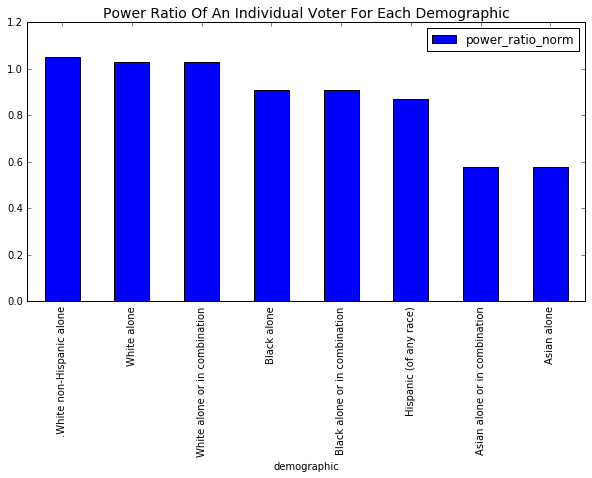

In [17]:
ax = demo_power[
    ~demo_power.index.isin(non_race)
][["power_ratio_norm"]].round(2).plot(kind="bar", figsize=(10,5))
ax.set_title("Power Ratio Of An Individual Voter For Each Demographic", size=14)
pass

## Distribution of Asian and Hispanic registered voters, by state

In [18]:
joined[
    joined["demographic"] == "Asian alone"
].sort_values("total_registered", ascending=False).head(10)[["state", "demographic", "total_registered", "power"]]

,state,demographic,total_registered,power
61,CALIFORNIA,Asian alone,1645.0,0.0
369,NEW YORK,Asian alone,384.0,0.0
490,TEXAS,Asian alone,299.0,0.0
347,NEW JERSEY,Asian alone,243.0,0.3
160,ILLINOIS,Asian alone,228.0,0.0
138,HAWAII,Asian alone,227.0,0.1
534,WASHINGTON,Asian alone,178.0,0.2
116,FLORIDA,Asian alone,174.0,2.5
523,VIRGINIA,Asian alone,136.0,2.3
248,MASSACHUSETTS,Asian alone,119.0,0.0


In [19]:
joined[
    joined["demographic"] == "Hispanic (of any race)"
].sort_values("total_registered", ascending=False).head(10)[["state", "demographic", "total_registered", "power"]]

,state,demographic,total_registered,power
62,CALIFORNIA,Hispanic (of any race),3684.0,0.0
491,TEXAS,Hispanic (of any race),2652.0,0.0
117,FLORIDA,Hispanic (of any race),1622.0,2.5
370,NEW YORK,Hispanic (of any race),983.0,0.0
40,ARIZONA,Hispanic (of any race),516.0,1.6
348,NEW JERSEY,Hispanic (of any race),468.0,0.3
161,ILLINOIS,Hispanic (of any race),415.0,0.0
359,NEW MEXICO,Hispanic (of any race),349.0,4.7
73,COLORADO,Hispanic (of any race),284.0,3.1
436,PENNSYLVANIA,Hispanic (of any race),225.0,2.7


# Analyzing Education Power

*Note: This section uses data from the [Current Population Survey](http://www.census.gov/cps/data/cpstablecreator.html). Instead of looking at all **registered voters**, which is not possible through the survey, we are analyzing all **adult citizens**.*

## Load Current Population Survey

In [20]:
cps_edu = pd.read_csv("../data/census/CPS Data - educational_attainment.csv")\
    .dropna(subset=["Total"])

In [21]:
cps_edu["State"] = cps_edu["State"].fillna(method="ffill")

In [22]:
cps_education = cps_edu\
    .set_index(["State", "Race"])\
    .stack()\
    .reset_index()\
    .rename(columns={"level_2": "education", 0: "total_citizens_raw"})

In [23]:
cps_education["total_citizens"] = cps_education["total_citizens_raw"].apply(lambda x: int(str(x).replace(",", "")))

In [24]:
def is_college_educated(education):
    if education in ["No high school diploma", "High school or equivalent"]:
        return False
    elif education in ["Some college less than 4-yr degree", "Bachelor's degree or higher"]:
        return True
    else:
        return None

In [25]:
cps_education["is_college_educated"] = cps_education["education"].apply(is_college_educated)

In [26]:
cps_education.head(5)

,State,Race,education,total_citizens_raw,total_citizens,is_college_educated
0,Totals,Totals,Total,"244,806,535",244806535,None
1,Totals,Totals,No high school diploma,"28,653,227",28653227,False
2,Totals,Totals,High school or equivalent,"70,882,009",70882009,False
3,Totals,Totals,Some college less than 4-yr degree,"70,150,254",70150254,True
4,Totals,Totals,Bachelor's degree or higher,"75,121,045",75121045,True


## Merge with "Voter Power Index"

In [27]:
joined_edu = pd.merge(
    cps_education,
    voter_power_index,
    left_on="State",
    right_on="abbrev",
    how="left"
).dropna(subset=["power"])

In [28]:
joined_edu["demo_power"] = joined_edu["total_citizens"] * joined_edu["power"]

## Analyze the data

In [29]:
# Create groups by race and education level
edu_grp = joined_edu.groupby(["Race", "is_college_educated"])
# Find the total power and the total number of citizens for each race-plus-education group
edu_power = pd.DataFrame({
    "total_power": edu_grp["demo_power"].sum(),
    "total_citizens": edu_grp["total_citizens"].sum(),
})
# Find the ratio of the total power to the total number of adult citizens
edu_power["power_ratio"] = edu_power["total_power"] / edu_power["total_citizens"]
edu_power = edu_power.sort_values("power_ratio", ascending=False)

In [30]:
edu_reset = edu_power.reset_index()
edu_reset[
    edu_reset["Race"] == "White alone"
]

,Race,is_college_educated,total_citizens,total_power,power_ratio
2,White alone,True,114703979,105893512.2,0.923190
3,White alone,False,77281676,69947423.3,0.905097


---

---

---